In [63]:
# !pip install catboost

In [64]:
# !pip install ml_metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
merged = pd.read_csv('data/merged_data.csv', index_col=None)
merged.head()

D:\programs\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,0,139128,1050,97633689,236.89,1,0.0,5045454,3573,122,119,-1,-1,-1,-1,-1,-1,-1
1,1,139128,1050,97633791,178.16,1,0.0,73719,5154,122,119,-1,-1,-1,-1,-1,-1,-1
2,2,139128,1050,97635201,173.28,1,0.0,7000939,2846,85,84,-1,-1,-1,-1,-1,-1,-1
3,3,139128,1050,97635312,73.69,1,0.0,7386015,3342,85,84,-1,-1,-1,-1,-1,-1,-1
4,4,139128,1050,97635414,282.14,1,0.0,73291,2846,85,84,-1,-1,-1,-1,-1,-1,-1


In [3]:
print(merged['user_id'].nunique())
print(merged['product_id'].nunique())
print(len(merged))

merged = merged[merged['product_id'] != 0]
print(len(merged))

107068
91994
21677070
21466723


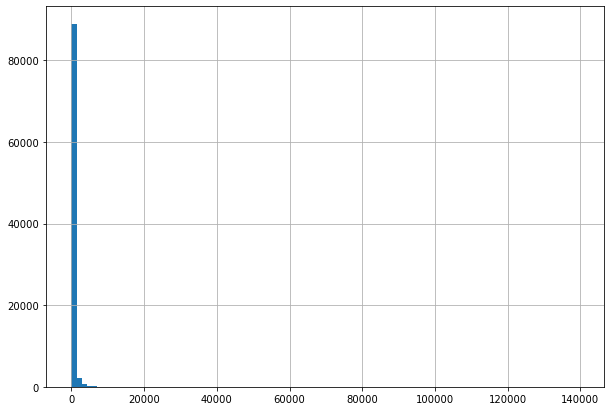

In [4]:
plt.figure(figsize=(10, 7))
merged['product_id'].value_counts().hist(bins=100)

In [5]:
merged['user_id'].nunique()

107066

In [6]:
groupby_0 = pd.DataFrame({'count' : merged.groupby(['product_id']).size()}).reset_index()
groupby_0 = groupby_0.sort_values(['count'], ascending=False)
groupby_0.head(3)

,product_id,count
193,709,139570
9290,39590,44804
71,166,36970


In [7]:
groupby_0['count'].sum()

21466723

In [8]:
# доля покрытия
groupby_0[:1000]['count'].sum() / groupby_0['count'].sum()

0.28358841729126516

In [9]:
# доля покрытия
groupby_0[:15000]['count'].sum() / groupby_0['count'].sum()

0.8288523124838384

In [10]:
# доля покрытия
groupby_0[:35000]['count'].sum() / groupby_0['count'].sum()

0.9561352238066332

In [11]:
# фильтруем по продуктам
top_products = groupby_0[:15000]['product_id'].tolist()

merged = merged[merged['product_id'].isin(top_products)]
print(len(merged))
print(merged['user_id'].nunique())

17792743
106621


In [12]:
users_n_orders = merged.groupby(['user_id'])['order_id'].nunique().to_frame('count').reset_index()
users_n_orders.head(3)

,user_id,count
0,51,17
1,65,23
2,400,5


In [13]:
valid_users = users_n_orders[users_n_orders['count'] >= 2]
valid_users_ids = valid_users['user_id'].tolist()
print('valid_users_ids', len(valid_users_ids))

merged = merged[merged['user_id'].isin(valid_users_ids)]
print(len(merged))

valid_users_ids 86647
17419118


In [14]:
merged_ = merged[merged['order_created_time'].values != -1]
merged_ = merged_[merged_['order_created_time'].values != '-1']
merged_ = merged_.drop(columns=['Unnamed: 0']) 

# Change data types to reduce memory footprint
merged_ = merged_.astype({
    'user_id': 'int32',
    'order_id': 'int32',
    'price': 'float32',
    'quantity': 'int32',
    'discount': 'float32',
    'product_id': 'int32',
    'brand_name': 'int32',
    'master_category_id': 'int32',
    'parent_category_id': 'int32',
    'order_created_time': str,
    'retailer': 'int32',
    'platform': 'int32',
    'city_name': 'int32',
    'gender': 'int32',
    'age': 'int32'}, copy=False)

merged_['order_created_time'] = pd.to_datetime(merged_['order_created_time'], format='%Y-%m-%d %H:%M:%S', exact=True)

In [15]:
merged_.dtypes

order_id                       int32
user_id                        int32
line_item_id                   int64
price                        float32
quantity                       int32
discount                     float32
product_id                     int32
brand_name                     int32
master_category_id             int32
parent_category_id             int32
order_created_time    datetime64[ns]
retailer                       int32
platform                       int32
city_name                      int32
gender                         int32
bdate                         object
age                            int32
dtype: object

In [16]:
merged_.head(3)

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
282503,5531326,691783,28336408,40.000000,1,6.990000,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282504,5531326,691783,28336410,139.000000,1,106.000000,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282505,5531326,691783,28336411,49.900002,1,39.990002,57951,104,581,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22


In [17]:
# last_order = merged_.groupby(['user_id'])['order_created_time'].max().to_frame('order_created_time').reset_index()
# last_order.head(3)

In [18]:
# target = pd.merge(merged_, last_order, on=['user_id', 'order_created_time']) 
# print(len(target))

# target_user_product_pos = target[['user_id', 'product_id']]
# target_user_product_pos['target'] = 1
# target_user_product_pos = target_user_product_pos.drop_duplicates()
# target_user_product_pos.head(3)

In [19]:
# # коряво
# last_order['user_date'] = last_order['user_id'].apply(str) + last_order['order_created_time'].apply(str)
# merged_['user_date'] = merged_['user_id'].apply(str) + merged_['order_created_time'].apply(str)

# merged_ = merged_[~merged_['user_date'].isin(set(last_order['user_date']))]
# len(merged_)

In [20]:
del merged

In [21]:
merged_.head(3)

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
282503,5531326,691783,28336408,40.000000,1,6.990000,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282504,5531326,691783,28336410,139.000000,1,106.000000,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282505,5531326,691783,28336411,49.900002,1,39.990002,57951,104,581,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22


In [22]:
features = merged_.groupby(['user_id', 'product_id', 'master_category_id', 
                            'parent_category_id']).agg(
    product_count=pd.NamedAgg(column='order_created_time', aggfunc='count'),
    avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
    max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
    min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),
#     max_date=pd.NamedAgg(column='order_created_time', aggfunc='max')
).reset_index()
            
features.head(3)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price
0,400,41,85,84,1,0.000,0.00,0.0,59.000000,59.000000,59.000000
1,400,177,26,20,2,9.995,19.99,0.0,64.895004,74.889999,54.900002
2,400,397,38,35,1,139.000,139.00,139.0,265.000000,265.000000,265.000000


In [23]:
features.to_csv('features.csv', header=True, index=False)